In [1]:
import random 
import pandas as pd
import numpy as np

In [2]:
from numpy import asarray
from numpy import save
from numpy import load

In [3]:
!pip install pypng

In [4]:
from PIL import Image
import png
import os

In [5]:
!pip install opencv-python


In [6]:
import json
import cv2
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [8]:
!pip install tensorflow

In [9]:
from tensorflow import keras
from keras import models
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import layers

In [10]:
!pip install scikeras

In [11]:
from scikeras.wrappers import KerasClassifier

In [12]:
!pip install --upgrade scikit-learn

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
import seaborn as sns

In [16]:
import pickle

In [17]:
import numpy as np

In [18]:
!pip install cairocffi


In [19]:
!pip install pycairo

In [20]:
import cairocffi as cairo

In [21]:
import numpy as np
import cairocffi as cairo

In [22]:
# https://github.com/googlecreativelab/quickdraw-dataset/issues/19
def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_image = raster_image.reshape((side, side))
        raster_images.append(raster_image)
    
    return raster_images

In [23]:
# airplane, apple, angel, alarm clock
def load_data(animal, side, n_images):
    """This function transforms a json file (with raw data of images) 
    into lists of 1,000 np.arrays with shape 256*256 (tensors of pixels),
    each representing a drawing of an animal 
    Input = 1 json file
    Output = 1,000 np.arrays"""
    animal_data = [json.loads(line) for line in open(f'raw_data/full_simplified_{animal}.ndjson', 'r')]
    animal_data = random.choices(animal_data, k=n_images)
    vector_images = [element['drawing'] for element in animal_data]
    data = vector_to_raster(vector_images, side=side, line_diameter=16, padding=16, bg_color=(1,1,1), fg_color=(0,0,0))
    return data

In [24]:
'''
import numpy as np

def main(filename):
    data = np.load(filename, encoding='latin1', allow_pickle=True)
    print(data)


    # 배열의 추가 정보 출력
    print("Array shape:", data.shape)
    print("Array dtype:", data.dtype)
    #print("Array min:", data.min())
    #print("Array max:", data.max())


if __name__ == "__main__":
    filename = './npy/animals/airplane.npy'
    main(filename)
'''

'\nimport numpy as np\n\ndef main(filename):\n    data = np.load(filename, encoding=\'latin1\', allow_pickle=True)\n    print(data)\n\n\n    # 배열의 추가 정보 출력\n    print("Array shape:", data.shape)\n    print("Array dtype:", data.dtype)\n    #print("Array min:", data.min())\n    #print("Array max:", data.max())\n\n\nif __name__ == "__main__":\n    filename = \'./npy/animals/airplane.npy\'\n    main(filename)\n'

In [25]:
def save_png(type_animal, data):
    """This function transforms np.arrays of pixels with shape 256*256 
    into .png (real images of resolution 256*256) and saves them in a subdirectory.
    Input = 1, 000 np. arrays 
    Output = 1,000 drawings of one type of animal (images.png)"""
    path = f'images/{type_animal}'
    if type_animal not in os.listdir('images/'):
        os.mkdir(path)
    for i in range(len(data)):
        img = data[i]
        png.from_array(np.array(img), 'L').save(f'{path}/img_{i}.png')

In [26]:
import numpy as np
import gc

In [27]:
def plot_samples(X, y, rows=1, cols=5, title=''):
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    

    # 데이터 타입을 float32로 변경
    X = X.astype(np.float32)
    y = y.reshape(-1, 1).astype(np.float32)  # y도 2차원 배열로 변경하고 타입을 맞춤

    # 메모리를 더 효율적으로 사용하기 위해 np.c_ 대신 np.concatenate 사용
    input_data = np.concatenate([X, y], axis=1)

    # 사용하지 않는 객체를 명시적으로 삭제하고 가비지 컬렉터 실행
    del X, y
    gc.collect()

    #input_data = np.c_[X, y]
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in (range(0, min(len(input_data),(rows*cols)))):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_data[i,:65536].reshape((256,256)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [28]:
def resizing_X(X_orig, small_side):
    """This function aims at resizing the original features X 
    (256*256) into smaller dimensions."""
    X = []
    for i in range(X_orig.shape[0]):
        X.append([])
        for j in range(X_orig.shape[1]):
            X[-1].append(cv2.resize(X_orig[i, j,], dsize=(small_side, small_side), interpolation=cv2.INTER_CUBIC))
    return np.array(X)

In [29]:
# dict with 2 classes 
class_dict_2 = { 
    'airplane': 0,
    'apple': 1, 
}

# dict with 4 classes 
class_dict_4 = {
    'airplane': 0,
    'apple': 1,  
    'alarm clock': 2,
    'angel': 3,
}

class_dict_4 = {
    'airplane': 0,
    'apple': 1,  
    'alarm clock': 2,
    'angel': 3,
}

In [30]:
n_images = 1000
side = 256

X = []
y = []

In [31]:
class_dict = class_dict_4
nb_classes = len(class_dict)

In [32]:
import json
import random

Animal airplane | Loading data into numpy array
Animal airplane | Saving numpy array as npy
Animal airplane | Building features and labels
Animal airplane | Plotting samples
Animal apple | Loading data into numpy array
Animal apple | Saving numpy array as npy
Animal apple | Building features and labels
Animal apple | Plotting samples
Animal alarm clock | Loading data into numpy array
Animal alarm clock | Saving numpy array as npy
Animal alarm clock | Building features and labels
Animal alarm clock | Plotting samples
Animal angel | Loading data into numpy array
Animal angel | Saving numpy array as npy
Animal angel | Building features and labels
Animal angel | Plotting samples


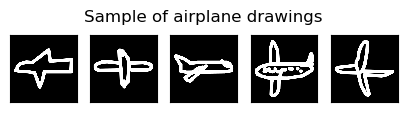

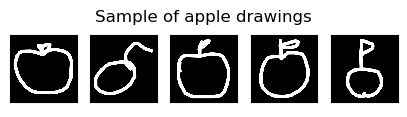

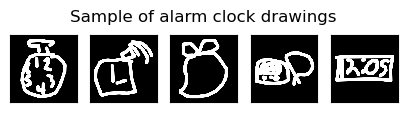

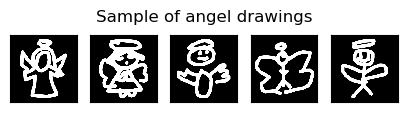

In [33]:
import os

# 디렉토리가 존재하는지 확인하고, 없으면 생성


for animal in class_dict:
    # Load the data into numpy arrays
    print(f'Class {animal} | Loading data into numpy array')
    data = load_data(animal, side, n_images)
    # Save numpy arrays as npy files
    print(f'Class {animal} | Saving numpy array as npy')
     # 추가
    directory = 'npy/animals'
   
    if not os.path.exists(directory):
        os.makedirs(directory)

    save(f'npy/animals/{animal}.npy', animal)
    # Save the data as images (.png)
    #print(f'Animal {animal} | Saving numpy array as png')
    #save_png(animal, data)
    # Build features and labels
    print(f'Class {animal} | Building features and labels')
    X_animal = np.array(data)
    X.append(X_animal)

    X_orig = X
    # Creating labels y_animal for each type of animal and appending it to a y tensor
    y_animal = np.zeros(n_images,) + class_dict[animal]
    y.append(y_animal)
    print(f'Class {animal} | Plotting samples')
    title =(f'Sample of {animal} drawings')
    plot_samples(X_animal, y_animal, rows=1, cols=5, title=title)
# new


X_orig = np.array(X_orig)
X = np.array(X)
y = np.array(y, dtype='uint8')

In [34]:
# Save the features and the labels
directory = 'npy/features_labels'
   
if not os.path.exists(directory):
    os.makedirs(directory)
np.save('npy/features_labels/X_orig.npy', X_orig)
np.save('npy/features_labels/y.npy', y)

# Neural Net

In [35]:
side = 256
small_side = 56
X = resizing_X(X_orig, small_side)

X_orig = X_orig.reshape(X_orig.shape[0] *X_orig.shape[1], side, side)
X = X.reshape(X.shape[0] * X.shape[1], small_side, small_side)
y = y.reshape(y.shape[0] * y.shape[1])

In [36]:
# Split the dataset into train and test sets (manually)
test_size = 0.33
train_images, test_images, train_images_orig, test_images_orig, train_labels, test_labels = train_test_split(X, X_orig, y, test_size = test_size, random_state = 69, shuffle = True)

# Prepare the data
train_images = train_images.reshape(train_images.shape[0], small_side*small_side)
train_images = train_images.astype('float32')/255
test_images = test_images.reshape(test_images.shape[0], small_side*small_side)
test_images = test_images.astype('float32')/255

# Build the network architecture (fully connected)
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(small_side*small_side,)))
network.add(layers.Dense(nb_classes, activation='softmax'))

opt = RMSprop(learning_rate=0.0001)

# Compile the model
network.compile(optimizer=opt, 
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
history = network.fit(train_images, 
                      train_labels, 
                      epochs=30,
                      batch_size=128, 
                      validation_data=(test_images, test_labels))

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3146 - loss: 2.3533 - val_accuracy: 0.5182 - val_loss: 1.1148
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5265 - loss: 1.1456 - val_accuracy: 0.5091 - val_loss: 1.0762
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6241 - loss: 0.8946 - val_accuracy: 0.6985 - val_loss: 0.8345
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6766 - loss: 0.8314 - val_accuracy: 0.5879 - val_loss: 0.9585
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6759 - loss: 0.7941 - val_accuracy: 0.7008 - val_loss: 0.8594
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7480 - loss: 0.6766 - val_accuracy: 0.6076 - val_loss: 0.9581
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7336 - loss: 0.7046 - val_accuracy: 0.7265 - val_loss: 0.6795
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7509 - loss: 0.6628 - val_accuracy: 0.6856 - v

In [38]:
# Evaluate the model
scores = network.evaluate(test_images, test_labels, verbose=0)
scores = round(scores[1]*100, 2)
print('Final network accuracy: ', scores, "%")

Final network accuracy:  78.94 %


In [39]:
'''# Predict classes for new data
for i in 20+np.array(range(10)):
    pred = list(class_dict)[network.predict(test_images)[i]]
    plt.imshow(test_images_orig[i].reshape((side, side)), cmap=plt.cm.binary)
    plt.title(f'Prediction: {pred}')
    plt.show()
    '''
'''
import numpy as np
import matplotlib.pyplot as plt

# 예측을 수행하고 최대 확률 인덱스를 클래스로 사용
pred_probs = network.predict(test_images)  # 모델로부터 클래스 확률을 예측
pred_classes = np.argmax(pred_probs, axis=1)  # 확률 배열에서 가장 높은 값을 가진 인덱스를 찾음

# 예측된 클래스 인덱스를 사용하여 레이블 가져오기
for i in 20 + np.array(range(10)):
    pred = list(class_dict)[pred_classes[i]]
    plt.imshow(test_images_orig[i].reshape((side, side)), cmap=plt.cm.binary)
    plt.title(f'Prediction: {pred}')
    plt.show()
'''


"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# 예측을 수행하고 최대 확률 인덱스를 클래스로 사용\npred_probs = network.predict(test_images)  # 모델로부터 클래스 확률을 예측\npred_classes = np.argmax(pred_probs, axis=1)  # 확률 배열에서 가장 높은 값을 가진 인덱스를 찾음\n\n# 예측된 클래스 인덱스를 사용하여 레이블 가져오기\nfor i in 20 + np.array(range(10)):\n    pred = list(class_dict)[pred_classes[i]]\n    plt.imshow(test_images_orig[i].reshape((side, side)), cmap=plt.cm.binary)\n    plt.title(f'Prediction: {pred}')\n    plt.show()\n"

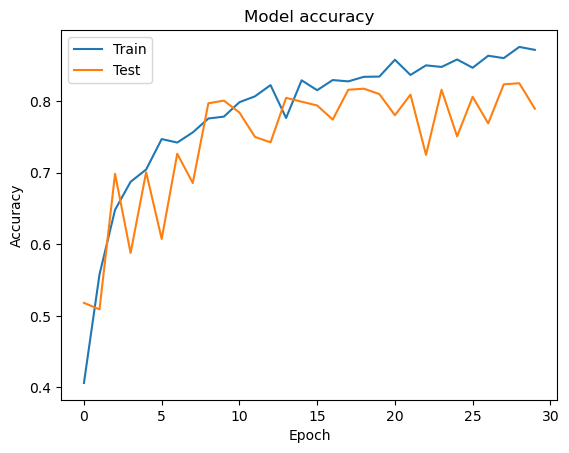

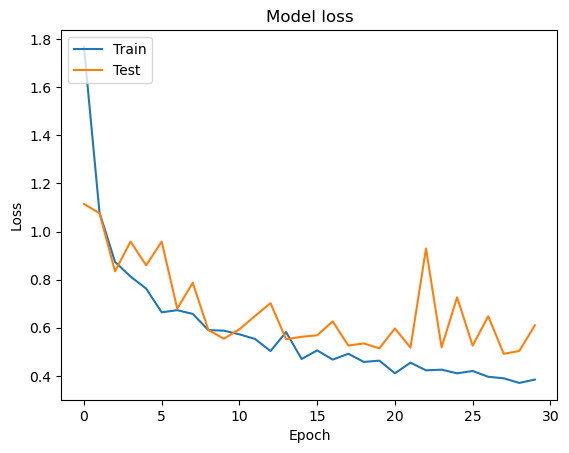

In [40]:
# Accuracy of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Loss of the model
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# K-fold Cross-Validation

In [41]:
X = X.reshape(X.shape[0], small_side*small_side)
X = X.astype('float32')/255
y = y.astype('uint8')

In [42]:
kfold = KFold(n_splits=5, random_state=None, shuffle=True)

cvscores = []
split_nb = 0
for train, test in kfold.split(X, y):
    split_nb += 1
    print('Split n°', split_nb)
    # Create the model
    k_network = models.Sequential()
    k_network.add(layers.Dense(512, activation='relu', input_shape=(small_side*small_side,)))
    k_network.add(layers.Dense(nb_classes, activation='softmax'))
    # Compile the model
    k_network.compile(optimizer='rmsprop', 
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
    # Fit the model
    k_network.fit(X[train], y[train], epochs=30, batch_size=128, verbose=0)
    # evaluate the model
    scores = k_network.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (k_network.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("\n%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Split n° 1
compile_metrics: 78.37%
Split n° 2
compile_metrics: 80.75%
Split n° 3
compile_metrics: 82.63%
Split n° 4
compile_metrics: 79.50%
Split n° 5
compile_metrics: 82.38%

80.73% (+/- 1.63%)


# Build the CNN model

In [43]:
# Re-load the data
X_orig = np.load('npy/features_labels/X_orig.npy')
y = np.load('npy/features_labels/y.npy')

In [44]:
# Reshape the data
side = 256
small_side = 28
X = resizing_X(X_orig, small_side)

X_orig = X_orig.reshape(X_orig.shape[0] *X_orig.shape[1], side, side)
X = X.reshape(X.shape[0] * X.shape[1], small_side, small_side)
y = y.reshape(y.shape[0] * y.shape[1])

In [45]:
# Split the dataset into train and test sets
test_size = 0.33
train_images, test_images, train_images_orig, test_images_orig, train_labels, test_labels = train_test_split(X, X_orig, y, test_size = test_size, random_state = 0, shuffle = True)

# Pre-process the data
train_images = train_images.reshape(train_images.shape[0], small_side, small_side, 1)
train_images = train_images.astype('float32')/255

test_images = test_images.reshape(test_images.shape[0], small_side, small_side, 1)
test_images = test_images.astype('float32')/255

In [46]:
def convnet_model(nb_classes, small_side):
    """This function is the architecture of the CNN model."""
    convnet = models.Sequential()
    convnet.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(small_side, small_side, 1)))
    convnet.add(layers.MaxPooling2D((2, 2)))
    convnet.add(layers.Conv2D(128, (3, 3), activation='relu'))
    convnet.add(layers.MaxPooling2D((2, 2)))
    convnet.add(layers.Dropout(0.4))
    convnet.add(layers.Flatten())
    convnet.add(layers.Dense(128, activation='relu'))
    convnet.add(layers.Dense(50, activation='relu'))
    convnet.add(layers.Dense(nb_classes, activation='softmax'))

    optimizer = Adam(learning_rate= 0.001)
    convnet.compile(optimizer='adam', 
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
    return convnet

In [47]:
# CNN with 2 classes
convnet_2 = convnet_model(nb_classes, small_side)
history_2 = convnet_2.fit(train_images, train_labels, epochs=20, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/20


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4137 - loss: 1.2561 - val_accuracy: 0.7265 - val_loss: 0.6998
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7587 - loss: 0.6153 - val_accuracy: 0.8212 - val_loss: 0.4930
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8273 - loss: 0.4862 - val_accuracy: 0.8227 - val_loss: 0.4590
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8423 - loss: 0.4386 - val_accuracy: 0.8742 - val_loss: 0.3728
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8715 - loss: 0.3774 - val_accuracy: 0.8848 - val_loss: 0.3343
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8885 - loss: 0.3358 - val_accuracy: 0.8985 - val_loss: 0.2976
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9035 - loss: 0.2760 - val_accuracy: 0.9053 - val_loss: 0.2806
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9179 - loss: 0.2633 - val_accuracy: 0.9061 - val_loss: 0.

In [48]:
# CNN with 4 classes of animals
convnet_1 = convnet_model(nb_classes, small_side)
history_1 = convnet_1.fit(train_images, train_labels, epochs=15, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4002 - loss: 1.2850 - val_accuracy: 0.6833 - val_loss: 0.7589
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7544 - loss: 0.6536 - val_accuracy: 0.8152 - val_loss: 0.4929
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8373 - loss: 0.4841 - val_accuracy: 0.8545 - val_loss: 0.4141
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8726 - loss: 0.3936 - val_accuracy: 0.8705 - val_loss: 0.3460
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8878 - loss: 0.3404 - val_accuracy: 0.9023 - val_loss: 0.3021
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9008 - loss: 0.3140 - val_accuracy: 0.8947 - val_loss: 0.2996
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9198 - loss: 0.2489 - val_accuracy: 0.9182 - val_loss: 0.2542
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9394 - loss: 0.2145 - val_accuracy: 0.9083 - v

# Evaluate the model

In [49]:
# Scores of the model with 2 classes
scores_2 = convnet_2.evaluate(test_images, test_labels, verbose=0)
scores_2 = round(scores_2[1]*100, 2)
print('Final CNN accuracy: ', scores_2, "%")

Final CNN accuracy:  91.97 %


In [50]:
# Scores of the model with 4 classes
scores_1 = convnet_1.evaluate(test_images, test_labels, verbose=0)
scores_1 = round(scores_1[1]*100, 2)
print('Final CNN accuracy: ', scores_1, "%")

Final CNN accuracy:  91.21 %


# Input Prediction

In [62]:
import numpy as np
import json
import os

def recursively_convert_to_list(item):
    if isinstance(item, np.ndarray):
        return recursively_convert_to_list(item.tolist())
    elif isinstance(item, list):
        return [recursively_convert_to_list(subitem) for subitem in item]
    else:
        return item

# 파일 경로 설정
file_path = 'output_file.ndjson'

# 파일이 이미 존재하는지 확인
if os.path.exists(file_path):
    print(f"Warning: '{file_path}' already exists and will be overwritten.")
else:
    print(f"'{file_path}' does not exist and will be created.")

# 파일 로드(파일 경로가 올바른지 확인 필요)
data = np.load('C:/Users/USER/Desktop/Image Classification/npy/features_labels/rdp_deltas.npy')

# .ndjson 파일로 저장
with open(file_path, 'w') as file:
    # 데이터가 NumPy 배열일 경우 리스트로 변환
    data_list = recursively_convert_to_list(data)

    # 리스트의 각 항목을 JSON 객체로 변환하여 저장
    for item in data_list:
        json_str = json.dumps(item)  # Python 객체를 JSON 문자열로 변환
        file.write(json_str + '\n')  # 파일에 쓰기


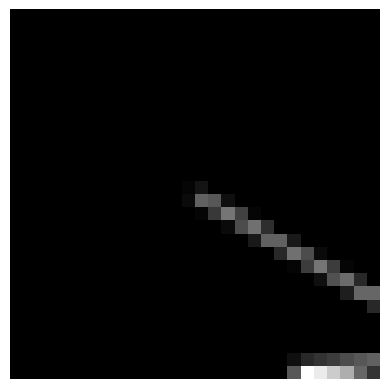

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image, ImageDraw\n\n# 데이터\ndata = [\n    [173, 100, 1], [-76, 1, 0], [-39, 14, 0], [-15, 11, 0], [-1, 17, 0], [6, 4, 0], [64, 2, 0], [41, -6, 0],\n    [55, -19, 0], [-3, -9, 0], [-13, -11, 0], [-30, -1, 0], [-32, 16, 1], [-4, -31, 0], [1, -32, 0], [10, 4, 0],\n    [14, 13, 0], [9, 17, 0], [6, 23, 0], [-97, 8, 1], [-1, 3, 0], [4, 3, 0], [21, -1, 0], [17, -6, 0],\n    [4, -5, 0], [-28, 2, 0], [-14, 6, 0], [55, 6, 1], [0, 34, 0], [4, 16, 0], [12, 18, 0], [11, 3, 0],\n    [7, -5, 0], [7, -13, 0], [3, -19, 0], [0, -27, 0], [-12, -18, 0], [25, -13, 1], [0, -25, 0], [4, -13, 0],\n    [9, -10, 0], [8, -1, 0], [13, 16, 0], [6, 12, 0], [1, 10, 0], [-21, 14, 0], [11, 3, 0], [13, 9, 0],\n    [7, 7, 0], [-1, 7, 0], [-6, 4, 0], [-23, 0, 0], [-23, -10, 0], [-10, -8, 0]\n]\n\n# 이미지 초기화\nwidth, height = 256, 256\nimage = Image.new('L', (width, height), 0)\ndraw = ImageDraw.Draw(image)\n\n# 중심점 설정\nx, y = width // 2, height // 2\n\n

In [76]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 제공된 델타 데이터
data = [
    [173, 100, 1], [-76, 1, 0], [-39, 14, 0], [-15, 11, 0], [-1, 17, 0], [6, 4, 0], [64, 2, 0], [41, -6, 0],
    [55, -19, 0], [-3, -9, 0], [-13, -11, 0], [-30, -1, 0], [-32, 16, 1], [-4, -31, 0], [1, -32, 0], [10, 4, 0],
    [14, 13, 0], [9, 17, 0], [6, 23, 0], [-97, 8, 1], [-1, 3, 0], [4, 3, 0], [21, -1, 0], [17, -6, 0],
    [4, -5, 0], [-28, 2, 0], [-14, 6, 0], [55, 6, 1], [0, 34, 0], [4, 16, 0], [12, 18, 0], [11, 3, 0],
    [7, -5, 0], [7, -13, 0], [3, -19, 0], [0, -27, 0], [-12, -18, 0], [25, -13, 1], [0, -25, 0], [4, -13, 0],
    [9, -10, 0], [8, -1, 0], [13, 16, 0], [6, 12, 0], [1, 10, 0], [-21, 14, 0], [11, 3, 0], [13, 9, 0],
    [7, 7, 0], [-1, 7, 0], [-6, 4, 0], [-23, 0, 0], [-23, -10, 0], [-10, -8, 0]
]

# 이미지 크기 및 초기 위치 설정
width, height = 256, 256  # 이미지 크기
image = Image.new('L', (width, height), 0)  # 검은색으로 초기화된 이미지 생성
draw = ImageDraw.Draw(image)  # ImageDraw 모듈 사용

x, y = width // 2, height // 2  # 시작 위치 (이미지 중앙)

# 데이터 기반으로 이미지 그리기
for dx, dy, pen in data:
    new_x, new_y = x + dx, y + dy
    if pen == 1:  # 펜이 붙어있으면 선을 그립니다.
        draw.line((x, y, new_x, new_y), fill=255)
    # 위치 업데이트
    x, y = new_x, new_y

# 이미지 크기 조정 (28x28)
resized_image = image.resize((28, 28), Image.BILINEAR)

# 이미지를 배열로 변환
image_array = np.array(resized_image)

# .npy 파일로 저장
np.save('drawing.npy', image_array)

# 결과 이미지 확인
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()

'''
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 데이터
data = [
    [173, 100, 1], [-76, 1, 0], [-39, 14, 0], [-15, 11, 0], [-1, 17, 0], [6, 4, 0], [64, 2, 0], [41, -6, 0],
    [55, -19, 0], [-3, -9, 0], [-13, -11, 0], [-30, -1, 0], [-32, 16, 1], [-4, -31, 0], [1, -32, 0], [10, 4, 0],
    [14, 13, 0], [9, 17, 0], [6, 23, 0], [-97, 8, 1], [-1, 3, 0], [4, 3, 0], [21, -1, 0], [17, -6, 0],
    [4, -5, 0], [-28, 2, 0], [-14, 6, 0], [55, 6, 1], [0, 34, 0], [4, 16, 0], [12, 18, 0], [11, 3, 0],
    [7, -5, 0], [7, -13, 0], [3, -19, 0], [0, -27, 0], [-12, -18, 0], [25, -13, 1], [0, -25, 0], [4, -13, 0],
    [9, -10, 0], [8, -1, 0], [13, 16, 0], [6, 12, 0], [1, 10, 0], [-21, 14, 0], [11, 3, 0], [13, 9, 0],
    [7, 7, 0], [-1, 7, 0], [-6, 4, 0], [-23, 0, 0], [-23, -10, 0], [-10, -8, 0]
]

# 이미지 초기화
width, height = 256, 256
image = Image.new('L', (width, height), 0)
draw = ImageDraw.Draw(image)

# 중심점 설정
x, y = width // 2, height // 2

# 데이터를 기반으로 이미지에 그리기
for dx, dy, pen in data:
    new_x, new_y = x + dx, y + dy
    if pen == 1:
        draw.line((x, y, new_x, new_y), fill=255)  # 펜이 내려진 상태일 때 선을 그립니다.
    x, y = new_x, new_y  # 펜 위치 업데이트

# 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 제거
plt.show()
'''

In [77]:
import numpy as np

# 데이터 불러오기
data = np.load('C:/Users/USER/Desktop/Image Classification/drawing.npy')

# 채널 차원 추가
data = data.reshape((28, 28, 1))

# 배치 차원 추가
data = np.expand_dims(data, axis=0)

# 데이터 타입 변경 및 정규화
data = data.astype('float32') / 255.0

# 모델 예측
predictions = convnet_1.predict(data)
predicted_class = np.argmax(predictions, axis=1)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: [3]
